# Homework for week04

> In this homework, we will use the Car price dataset like last week.
>
> We'll work with the MSRP variable, and we'll transform it to a classification task.

For the rest of the homework, you'll need to use only these columns:

- Make,
- Model,
- Year,
- Engine HP,
- Engine Cylinders,
- Transmission Type,
- Vehicle Style,
- highway MPG,
- city mpg
- MSRP

## Import packages

In [1]:
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score

## Data Preparation

In [2]:
def load_prepare_data():

    # load the data
    print(f'Reading csv file into dataframe....')
    df = pd.read_csv('../data/data-hmwk-3.csv')
    print(f'Original df.shape: {df.shape}')

    # clean/prepare the data
    print(f'cleaning data....')
    df.columns = df.columns.str.replace(' ', '_').str.lower()
    df.columns = df.columns.str.replace('msrp', 'price')
    
    # remove duplicates
    # print(f'removing duplicated records....')
    # df.drop_duplicates(inplace=True)

    # identify features and target
    features = ['make', 'model', 'year', 'engine_hp', 'engine_cylinders',  
                      'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg'
                    ]
    target = ['price']

    # use a subset for analysis
    df = df[features+target]

    # impute Nan/nulls with 0
    print(f'imputing NULLs....')
    df = df.fillna(0)

    # calculate the mean for price column
    print(f'binarizing target series....')
    mean_price = df.price.mean()
    # create a new column called 'above_average' that is set to 1 if value is above the mean_price
    df['above_average'] = [1 if price > mean_price else 0 for price in df['price']] 

    # remove price as target and replace with 'above_average'
    del df['price']
    target = ['above_average']

    return df


In [3]:
data = load_prepare_data()

Reading csv file into dataframe....
Original df.shape: (11914, 16)
cleaning data....
imputing NULLs....
binarizing target series....


In [4]:
data.head().T

,0,1,2,3,4
make,BMW,BMW,BMW,BMW,BMW
model,1 Series M,1 Series,1 Series,1 Series,1 Series
year,2011,2011,2011,2011,2011
engine_hp,335.0,300.0,300.0,230.0,230.0
engine_cylinders,6.0,6.0,6.0,6.0,6.0
transmission_type,MANUAL,MANUAL,MANUAL,MANUAL,MANUAL
vehicle_style,Coupe,Convertible,Coupe,Coupe,Convertible
highway_mpg,26,28,28,28,28
city_mpg,19,19,20,18,18
above_average,1,1,0,0,0


In [5]:
data.describe()

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg,above_average
count,11914.000000,11914.000000,11914.000000,11914.000000,11914.000000,11914.000000
mean,2010.384338,247.941749,5.614655,26.637485,19.733255,0.274383
std,7.579740,110.507669,1.800554,8.863001,8.987798,0.446222
min,1990.000000,0.000000,0.000000,12.000000,7.000000,0.000000
25%,2007.000000,170.000000,4.000000,22.000000,16.000000,0.000000
50%,2015.000000,225.000000,6.000000,26.000000,18.000000,0.000000
75%,2016.000000,300.000000,6.000000,30.000000,22.000000,1.000000
max,2017.000000,1001.000000,16.000000,354.000000,137.000000,1.000000


### Split the data

In [6]:
# split the data to train/val/test sets with 60%/20%/20% distribution
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# set the y dataframe
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

# remove target from df
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

## Question 1: ROC AUC feature importance

> ROC AUC could also be used to evaluate feature importance of numerical variables.
> 
>Let's do that
> 
>     For each numerical variable, use it as score and compute AUC with the above_average variable
>     Use the training dataset for that
> 
> If your AUC is < 0.5, invert this variable by putting "-" in front
> 
> (e.g. -df_train['engine_hp'])
> 
> AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change > the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [7]:
df_full_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9531 entries, 2711 to 235
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               9531 non-null   object 
 1   model              9531 non-null   object 
 2   year               9531 non-null   int64  
 3   engine_hp          9531 non-null   float64
 4   engine_cylinders   9531 non-null   float64
 5   transmission_type  9531 non-null   object 
 6   vehicle_style      9531 non-null   object 
 7   highway_mpg        9531 non-null   int64  
 8   city_mpg           9531 non-null   int64  
 9   above_average      9531 non-null   int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 819.1+ KB


In [8]:
categorical_columns = list(df_full_train.select_dtypes(include=['category', 'object']).columns)
numerical_columns = list(df_full_train.select_dtypes(include=['number']).columns)

In [9]:
categorical_columns

['make', 'model', 'transmission_type', 'vehicle_style']

In [10]:
numerical_columns

['year',
 'engine_hp',
 'engine_cylinders',
 'highway_mpg',
 'city_mpg',
 'above_average']

In [11]:
df_full_train[['engine_hp', 'highway_mpg', 'city_mpg', 'above_average']].reset_index(drop=True).head()

,engine_hp,highway_mpg,city_mpg,above_average
0,382.0,22,15,1
1,332.0,26,18,0
2,285.0,24,18,0
3,350.0,26,19,1
4,200.0,31,21,0


In [12]:
df_full_train[numerical_columns]

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg,above_average
2711,2007,382.0,8.0,22,15,1
333,2016,332.0,6.0,26,18,0
9377,2017,285.0,6.0,24,18,0
939,2016,350.0,6.0,26,19,1
5675,2013,200.0,4.0,31,21,0
...,...,...,...,...,...,...
7813,2016,272.0,6.0,26,18,1
10955,2015,381.0,8.0,17,13,1
905,1997,150.0,4.0,26,18,0
5192,2009,164.0,4.0,33,22,0


In [13]:
df_full_train.above_average.value_counts()

above_average
0    6924
1    2607
Name: count, dtype: int64

In [14]:
df_full_train.above_average.mean()

0.2735284859930752

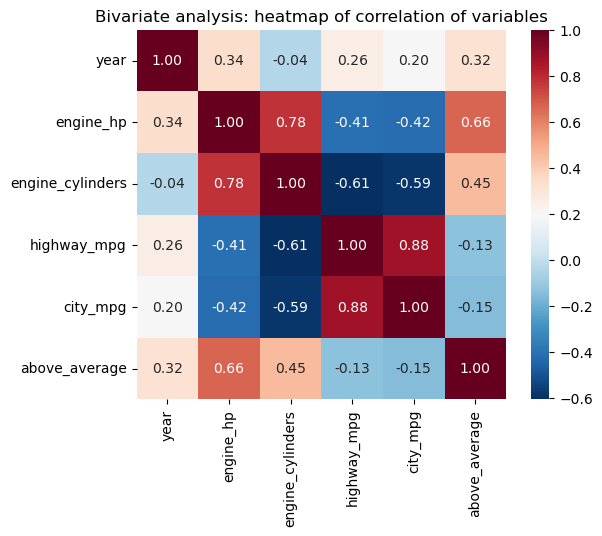

In [15]:
sns.heatmap(df_full_train[numerical_columns].corr(), annot=True, fmt='.2f', cmap='RdBu_r', square=True)
plt.title('Bivariate analysis: heatmap of correlation of variables')
plt.show()

In [16]:
for col in ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']:
    auc_score = roc_auc_score(df_full_train['above_average'], df_full_train[col])
    if auc_score < 0.5 :
        auc_score = roc_auc_score(df_full_train['above_average'], -df_full_train[col])
    print(f'AUC score for {col}: {auc_score:.2f}')


AUC score for engine_hp: 0.92
AUC score for engine_cylinders: 0.77
AUC score for highway_mpg: 0.63
AUC score for city_mpg: 0.67


### notes
(auc_score < 0.5) condition not checked, we get below variables < 0.5

> AUC score for highway_mpg: 0.37<br>
> AUC score for city_mpg: 0.33

Answers with duplicates dropped, which is not part of instructions, is similarly close. Qn2's answer however is different when duplicates are dropped, so the code is removed/commented for now.

```python
df.drop_duplicates(inplace=True)
```
> AUC score for engine_hp: 0.92<br>
> AUC score for engine_cylinders: 0.77<br>
> AUC score for highway_mpg: 0.64<br>
> AUC score for city_mpg: 0.68<br>


### qn1 ans: `engine_hp`

q: Which numerical variable (among the following 4) has the highest AUC?

a: `engine_hp`


## Question 2: Training the model

> Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

> LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [17]:
def perform_ohe(df_train, df_val):
    # perform OHE on categorical data; made sparse due to non-convergence otherwise
    dv = DictVectorizer(sparse=True)

    train = df_train.reset_index(drop=True)
    val = df_val.reset_index(drop=True)

    train_dict = train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = val.to_dict(orient='records')
    X_val = dv.transform(val_dict)

    # print(X.shape, y.shape)
    return X_train, X_val

In [18]:
X_train, X_val = perform_ohe(df_train, df_val)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f'{auc.round(4) }')            # `0.970` when duplicates dropped
print(f'{auc.round(4) - 0.979}') # this is the closest answer
print(f'{auc.round(4) - 0.878}')

0.9796
0.0006000000000000449
0.10160000000000002


### qn2 ans: `0.979`

Q: What's the AUC of this model on the validation dataset? (round to 3 digits)

A: `0.979`

## Question 3: Precision and Recall

> Now let's compute precision and recall for our model.
>
>    - Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
>    - For each threshold, compute precision and recall
>    - Plot them


In [19]:
# code is from lesson
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [20]:
# code is from lesson
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [21]:
# code is from lesson
# plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
# plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
# plt.legend()

Definitions:

- _precision_ : fraction of **POSITIVE** predictions that are **CORRECT**
$$precision = tp / (tp + fp)$$
- _recall_ : fraction of **CORRECT**ly identified **POSITIVE** samples
$$recall = tp / (tp + fn)$$
- _fpr_ : False Positive Rate
$$fpr = fp / (tn + fp)$$
- _tpr_ : True Positive Rate
$$tpr = fn / (fn + tp)$$

In [22]:
# code is from lesson
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

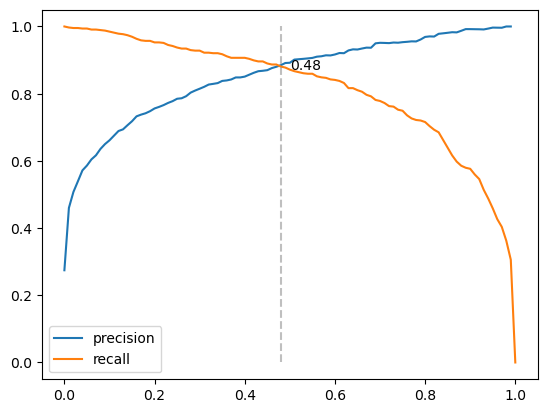

In [23]:
# code is from lesson
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.48, 0, 1, color='grey', linestyle='--', alpha=0.5)
plt.annotate("0.48",  (0.5,0.87))
plt.legend()
plt.show()

### qn3 ans: `0.48`

Q: At which threshold precision and recall curves intersect?

A: `0.48` (drop_duplicates gives 0.44)


## Question 4: F1 score

> Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

> This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

> Where $P$ is precision and $R$ is recall.

> Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [24]:
# use above formula and add to same dataframe
df_scores['f1'] = 2 * (df_scores.p * df_scores.r / (df_scores.p + df_scores.r))

In [25]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr,p,r,f1
0,0.0,654,1729,0,0,1.000000,1.000000,0.274444,1.000000,0.430688
10,0.1,644,330,10,1399,0.984709,0.190862,0.661191,0.984709,0.791155
20,0.2,623,201,31,1528,0.952599,0.116252,0.756068,0.952599,0.843031
30,0.3,607,138,47,1591,0.928135,0.079815,0.814765,0.928135,0.867763
40,0.4,593,104,61,1625,0.906728,0.060150,0.850789,0.906728,0.877868
50,0.5,570,69,84,1660,0.871560,0.039907,0.892019,0.871560,0.881671
60,0.6,550,50,104,1679,0.840979,0.028918,0.916667,0.840979,0.877193
70,0.7,509,26,145,1703,0.778287,0.015038,0.951402,0.778287,0.856182
80,0.8,468,15,186,1714,0.715596,0.008676,0.968944,0.715596,0.823219
90,0.9,377,3,277,1726,0.576453,0.001735,0.992105,0.576453,0.729207


In [26]:
print(f'{df_scores["f1"].max() = }')

# idx is in tens and thresholds in 1/100, so multiply idx*001 to get threshold value
max_f1_threshold = df_scores['f1'].idxmax()*0.01 
print(f'{max_f1_threshold = }')

df_scores["f1"].max() = 0.884437596302003
max_f1_threshold = 0.49


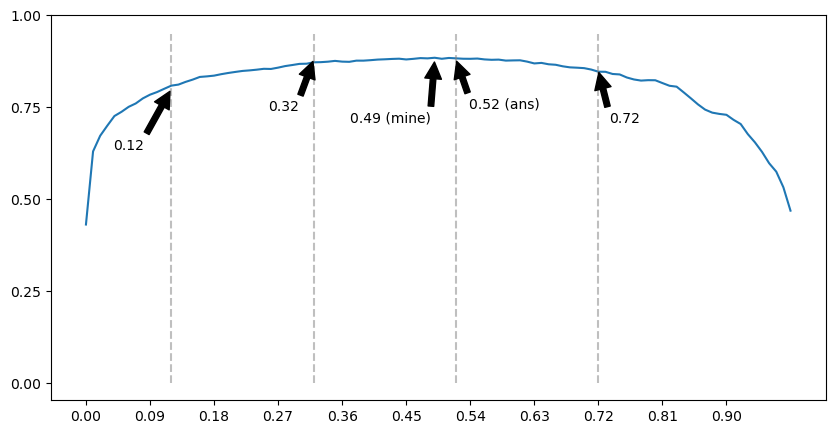

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))

line = ax.plot(df_scores.threshold, df_scores.f1)
dash = ax.vlines((0.12, 0.32, 0.52, 0.72), 0.0, 0.95, color='grey', linestyle='--', alpha=0.5)
ax.annotate('0.12',
            xy=(0.12, 0.8), xycoords='data',
            xytext=(0.12, 0.68), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')
ax.annotate('0.32',
            xy=(0.32, 0.88), xycoords='data',
            xytext=(0.32, 0.78), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')
ax.annotate('0.49 (mine)',
            xy=(0.49, 0.88), xycoords='data',
            xytext=(0.49, 0.75), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')
ax.annotate('0.52 (ans)',
            xy=(0.52, 0.88), xycoords='data',
            xytext=(0.54, 0.75), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom')
ax.annotate('0.72',
            xy=(0.72, 0.85), xycoords='data',
            xytext=(0.72, 0.75), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='top')
plt.xticks(np.linspace(0, 0.9, 11))
plt.yticks(np.linspace(0.0, 1.0, 5))
plt.show()

### qn4 ans: `0.52`

Q: At which threshold F1 is maximal?

A: `0.49` take closest `0.52`

## Question 5: 5-Fold CV

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

In [28]:
categorical_columns

['make', 'model', 'transmission_type', 'vehicle_style']

In [29]:
numerical_columns

['year',
 'engine_hp',
 'engine_cylinders',
 'highway_mpg',
 'city_mpg',
 'above_average']

In [30]:
numerical_columns.remove('above_average')

In [31]:
def train(df_train, y_train):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict_prob(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict(X)

    return y_pred

In [32]:
scores = []
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

In [33]:
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    # set the y dataframe
    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    # remove target from df
    del df_train['above_average']
    del df_val['above_average']

    dv, model = train(df_train, y_train)
    y_pred = predict_prob(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f'mean auc: {np.mean(scores):.3f}, std: +-{np.std(scores):.3f}')

0it [00:00, ?it/s]

mean auc: 0.980, std: +-0.004


### qn5 ans: `0.003`

Q: How large is standard devidation of the scores across different folds?

A: `0.004`

## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.01, 0.1, 0.5, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


In [34]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [35]:
scores_dict = {}
for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        # set the y dataframe
        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        # remove target from df
        del df_train['above_average']
        del df_val['above_average']

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict_prob(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        f1 = f1_score(y_val, predict(df_val, dv, model))
        scores.append(auc)
        
    print(f'loop, C= {C}, mean auc: {np.mean(scores)}, f1 score: {f1}')
        
    scores_dict[repr(C)] = { 'mean auc' : np.mean(scores).round(3)
                                          , 'std var' : '+-'+repr(np.std(scores).round(5))
                                    }


  0%|          | 0/4 [00:00<?, ?it/s]

loop, C= 0.01, mean auc: 0.951586217232536, f1 score: 0.7868852459016393
loop, C= 0.1, mean auc: 0.9714610967548774, f1 score: 0.8475247524752476
loop, C= 0.5, mean auc: 0.9772229255679227, f1 score: 0.8590733590733591
loop, C= 10, mean auc: 0.9814560537891961, f1 score: 0.8582375478927202


In [36]:
from pprint import pprint

pprint(scores_dict, indent=5)


{    '0.01': {'mean auc': 0.952, 'std var': '+-0.00249'},
     '0.1': {'mean auc': 0.971, 'std var': '+-0.00123'},
     '0.5': {'mean auc': 0.977, 'std var': '+-0.0016'},
     '10': {'mean auc': 0.981, 'std var': '+-0.00287'}}


### qn6 ans: `10`

Q: Which C leads to the best mean score?

A: `10`

## Extras

### EDA

- what if we change 'year', 'engine_cylinders',  'above_average' variables to categorical variables, would the answers differ?

In [37]:
data = load_prepare_data()
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)

Reading csv file into dataframe....
Original df.shape: (11914, 16)
cleaning data....
imputing NULLs....
binarizing target series....


In [38]:
df_full_train[['year', 'engine_cylinders', 'above_average']] = df_full_train[['year'
                                                                              , 'engine_cylinders'
                                                                              ,  'above_average']].astype('category')

In [39]:
df_full_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9531 entries, 2711 to 235
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   make               9531 non-null   object  
 1   model              9531 non-null   object  
 2   year               9531 non-null   category
 3   engine_hp          9531 non-null   float64 
 4   engine_cylinders   9531 non-null   category
 5   transmission_type  9531 non-null   object  
 6   vehicle_style      9531 non-null   object  
 7   highway_mpg        9531 non-null   int64   
 8   city_mpg           9531 non-null   int64   
 9   above_average      9531 non-null   category
dtypes: category(3), float64(1), int64(2), object(4)
memory usage: 625.4+ KB


In [40]:
df_full_train.describe(percentiles=[0.1, .25, .5, .75, 0.99])

,engine_hp,highway_mpg,city_mpg
count,9531.000000,9531.000000,9531.000000
mean,248.046585,26.623439,19.734131
std,110.937826,9.115060,9.167786
min,0.000000,12.000000,7.000000
10%,137.000000,18.000000,13.000000
25%,170.000000,22.000000,16.000000
50%,225.000000,25.000000,18.000000
75%,300.000000,30.000000,22.000000
99%,620.000000,46.000000,44.000000
max,1001.000000,354.000000,137.000000


It's evident from the `min` to `10th` percentile and `99th` percentile to `max`, our dataset has outliers.

In [41]:
categorical_columns = list(df_full_train.select_dtypes(include=['category', 'object']).columns)
numerical_columns = list(df_full_train.select_dtypes(include=['number']).columns)

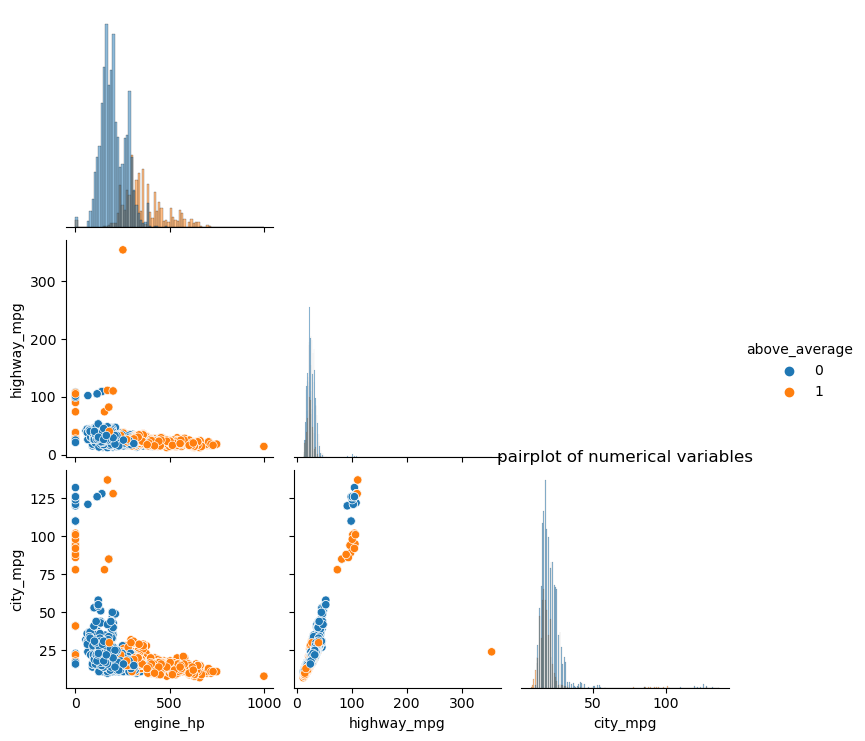

In [42]:
sns.pairplot(df_full_train, hue='above_average',  diag_kind="hist", corner=True)
plt.title('pairplot of numerical variables')
plt.show()

`city_mpg` and `highway_mpg` has long tail, and outliers as already discovered above, and confirmed by the `boxplot` below.

Not just needing to treat outliers and long-tail distribution, we also have to scale the numerical data as the y-axes show that they have different values.

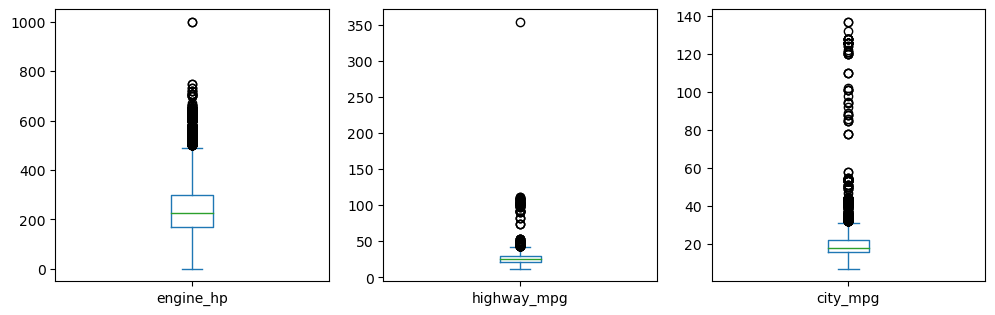

In [43]:
df_full_train.plot.box(figsize=(12, 12), layout=(3,3), subplots=True, sharex=False, sharey=False)
plt.show()

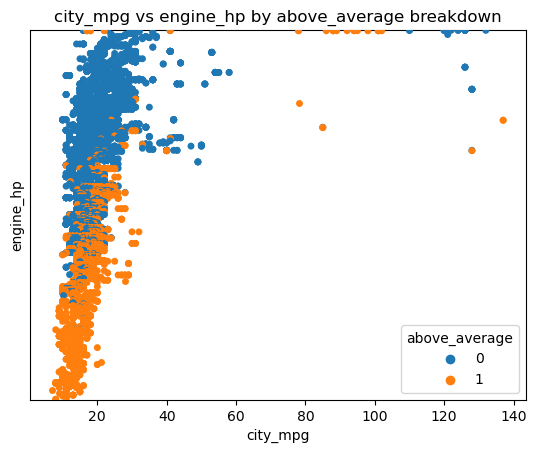

In [44]:
sns.stripplot(df_full_train, x="city_mpg", y="engine_hp", hue="above_average", orient='h', dodge=True)
plt.title('city_mpg vs engine_hp by above_average breakdown')
plt.yticks([])
plt.show()

In [45]:
categorical_columns.remove('above_average')

In [46]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict_prob(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict(X)

    return y_pred

In [47]:
scores = []
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

In [48]:
scores_dict = {}
for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        # display(df_train.head())

        # set the y dataframe
        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        # remove target from df
        del df_train['above_average']
        del df_val['above_average']
        # display(df_train.head())

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict_prob(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        f1 = f1_score(y_val, predict(df_val, dv, model))
        scores.append(auc)
        scores.append(f1)

    print(f'loop, C= {C}, mean auc: {np.mean(scores)}, f1 score: {f1}')
        
    scores_dict[repr(C)] = { 'mean auc' : np.mean(scores).round(3)
                                          , 'std var' : '+-'+repr(np.std(scores).round(5))
                                          , 'mean f1' : np.mean(scores).round(5)
                                    }


  0%|          | 0/4 [00:00<?, ?it/s]

loop, C= 0.01, mean auc: 0.8690765325624239, f1 score: 0.7868852459016393
loop, C= 0.1, mean auc: 0.9104978778021187, f1 score: 0.8475247524752476
loop, C= 0.5, mean auc: 0.921088885516378, f1 score: 0.8590733590733591
loop, C= 10, mean auc: 0.9339376443832407, f1 score: 0.8582375478927202


In [49]:
X = df_train[['city_mpg', 'engine_hp']]
dicts = X.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)

model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(C=10, max_iter=1000, solver='liblinear')

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7625 entries, 333 to 235
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   city_mpg   7625 non-null   int64  
 1   engine_hp  7625 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 178.7 KB


b:\miniforge3\envs\zoomcamp\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


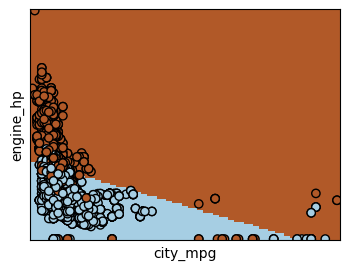

In [51]:
from sklearn.inspection import DecisionBoundaryDisplay
_, ax = plt.subplots(figsize=(4, 3))
DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    cmap=plt.cm.Paired,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    xlabel="city_mpg",
    ylabel="engine_hp",
    eps=0.5,
)

# Plot also the training points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_train, edgecolors="k", cmap=plt.cm.Paired)

plt.xticks(())
plt.yticks(())

plt.show()